In [87]:
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input, Conv1D, Flatten,\
                                    Reshape, MaxPooling1D,\
                                    Dropout, Conv1DTranspose, UpSampling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from IPython import display # If using IPython, Colab or Jupyter
import numpy as np
from pyfaidx import Fasta
from multiprocessing import Pool
from sklearn.model_selection import train_test_split
import pandas as pd

In [88]:
def encode_sequence(seq):
    
    d = {
    'A' : [1, 0, 0, 0],
    'C' : [0, 1, 0, 0],
    'G' : [0, 0, 1, 0],
    'T' : [0, 0, 0, 1], 
    'N' : [0.25, 0.25, 0.25, 0.25]}

    return np.array([d[nuc] for nuc in list(seq)]).astype('float32')

In [89]:
latent_dim = 256
# filters = 128
# kernel_size = 32
# layer_filters = [128, 128]

In [90]:
from tensorflow.keras.optimizers import Adam
img = Input(shape = (512, 4))
x = img

x = Conv1D(filters=512,
           kernel_size=32,
           activation='relu',
           strides=1,
           padding='same')(x)

x = MaxPooling1D(8)(x)

x = Conv1D(filters=128,
           kernel_size=8,
           activation='relu',
           strides=1,
           padding='same')(x)

x = MaxPooling1D(2)(x)
shape = K.int_shape(x)

x = Flatten()(x)
x = Dense(1028)(x)
x = Dense(512)(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(img,
                latent,
                name='encoder')
encoder.summary()
# plot_model(encoder,
#            to_file='encoder.png',
#            show_shapes=True)

latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(512)(latent_inputs)
x = Dense(1028)(x)
x = Dense(shape[1] * shape[2])(x)
x = Reshape((shape[1], shape[2]))(x)
x = UpSampling1D(size=2)(x)
x = Conv1DTranspose(128, kernel_size=8, strides=1, padding="same")(x)
x = UpSampling1D(size=8)(x)
x = Conv1DTranspose(512, kernel_size=32, strides=1, padding="same")(x)
outputs = Conv1DTranspose(filters=4,
                          kernel_size=32,
                          activation='relu',
                          padding='same',
                          name='decoder_output')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 512, 4)]          0         
                                                                 
 conv1d_14 (Conv1D)          (None, 512, 512)          66048     
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 64, 512)          0         
 g1D)                                                            
                                                                 
 conv1d_15 (Conv1D)          (None, 64, 128)           524416    
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 32, 128)          0         
 g1D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 4096)              0   

In [91]:
autoencoder = Model(img,
                    decoder(encoder(img)),
                    name='autoencoder')
autoencoder.summary()
# plot_model(autoencoder,
#            to_file='autoencoder.png',
#            show_shapes=True)

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer=Adam(.0001))

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 512, 4)]          0         
                                                                 
 encoder (Functional)        (None, 256)               5460356   
                                                                 
 decoder (Functional)        (None, 512, 4)            7168136   
                                                                 
Total params: 12,628,492
Trainable params: 12,628,492
Non-trainable params: 0
_________________________________________________________________


In [92]:
latent_vector = encoder(img)
output = decoder(latent_vector)

In [93]:
model = Model(inputs = img, outputs = output)
model.compile("adam", loss = "mean_squared_error")

In [94]:
genomeFasta = "/home/gregory.andrews-umw/data/genome/hg38.fa"
genome = Fasta(genomeFasta, sequence_always_upper=True, as_raw=True)
seqs = []
bCREs = "bCREs_all.bed"
with open(bCREs) as f:
    for line in f:
        split = line.strip().split("\t")
        chrom, start, stop = split[:3]
        start, stop = int(start), int(stop)
        center = (start + stop) // 2
        seqs.append(genome[chrom][center-256:center+256])

In [95]:
with Pool(8) as p:
    X = p.map(encode_sequence, seqs)

In [96]:
X = np.stack(X, axis=0)

In [97]:
y = np.zeros(X.shape[0])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [69]:
autoencoder.fit(X_train,
                X_train,
                validation_data=(X_test, X_test),
                epochs=10,
                batch_size=32)

Epoch 1/10
10177/10177 [==============================] - 173s 17ms/step - loss: 0.1579 - val_loss: 0.1490
Epoch 2/10
10177/10177 [==============================] - 171s 17ms/step - loss: 0.1463 - val_loss: 0.1437
Epoch 3/10
10177/10177 [==============================] - 170s 17ms/step - loss: 0.1422 - val_loss: 0.1411
Epoch 4/10
10177/10177 [==============================] - 171s 17ms/step - loss: 0.1406 - val_loss: 0.1404
Epoch 5/10
10177/10177 [==============================] - 170s 17ms/step - loss: 0.1386 - val_loss: 0.1366
Epoch 6/10
10177/10177 [==============================] - 171s 17ms/step - loss: 0.1357 - val_loss: 0.1349
Epoch 7/10
10177/10177 [==============================] - 171s 17ms/step - loss: 0.1343 - val_loss: 0.1341
Epoch 8/10
10177/10177 [==============================] - 171s 17ms/step - loss: 0.1337 - val_loss: 0.1337
Epoch 9/10
10177/10177 [==============================] - 171s 17ms/step - loss: 0.1333 - val_loss: 0.1332
Epoch 10/10
10177/10177 [============

In [85]:
autoencoder.save_weights("autoencoder.h5")

In [86]:
encoder.save_weights("encoder.h5")

In [99]:
encoder.load_weights("encoder.h5")

In [100]:
X_latent = encoder.predict(X)

In [102]:
from sklearn.manifold import TSNE

In [103]:
tsne = TSNE().fit_transform(X_latent)

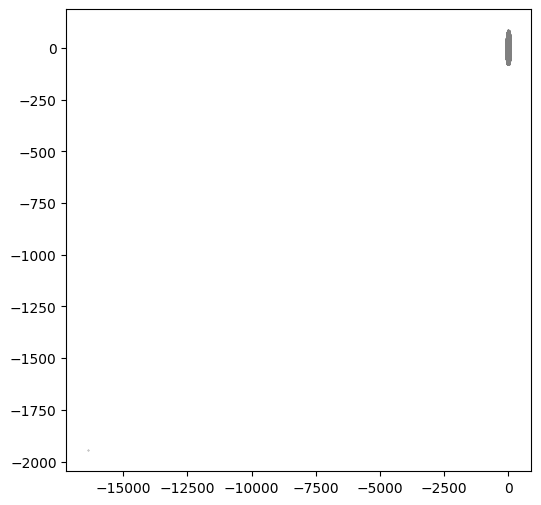

In [105]:
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(tsne[:,0], tsne[:,1], s=.1, color="gray")

In [71]:
import umap

In [72]:
u = umap.UMAP().fit_transform(X_latent)

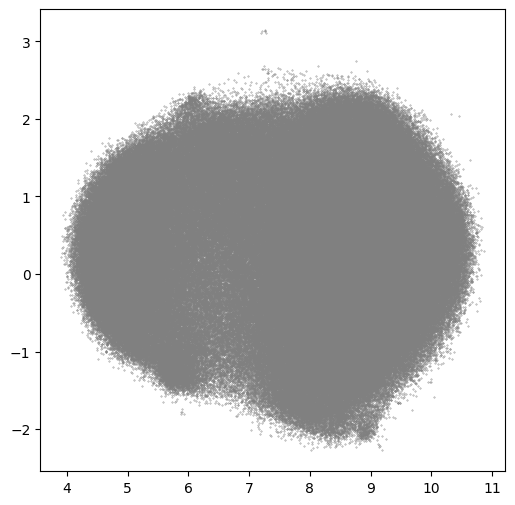

In [73]:
fig, ax = plt.subplots(figsize=(6,6))
# for i in range(10):
#     indices = np.where(y_train == i)
#     ax.scatter(u[indices,0], u[indices,1], s=.1, label=i)

# ax.legend(loc='upper right', markerscale=10)
ax.scatter(u[:,0], u[:,1], s=.1, color="gray")

In [74]:
data = pd.read_csv("~/psychScreen/Corces/Corces.txt", sep="\t", header=0)

In [75]:
data.head()

,chrom,start,stop,rDHS,Microglia,Oligodendrocytes,ExcitatoryNeurons,NigralNeurons,OPCs,Astrocytes,InhibitoryNeurons,nCells
0,chr1,181289,181639,EH38D4327525,0,0,0,0,0,0,0,0
1,chr1,191294,191644,EH38D4327540,0,1,0,1,1,1,1,5
2,chr1,267925,268171,EH38D4327544,0,1,1,0,1,1,1,5
3,chr1,586036,586264,EH38D4327554,0,1,1,0,1,1,1,5
4,chr1,605330,605668,EH38D4327560,0,0,1,0,0,0,0,1


In [82]:
indices = data.index[(data["ExcitatoryNeurons"] == 1) & (data["nCells"] == 1)]
indices = data.index[(data["Microglia"] == 1) & (data["nCells"] == 1)]

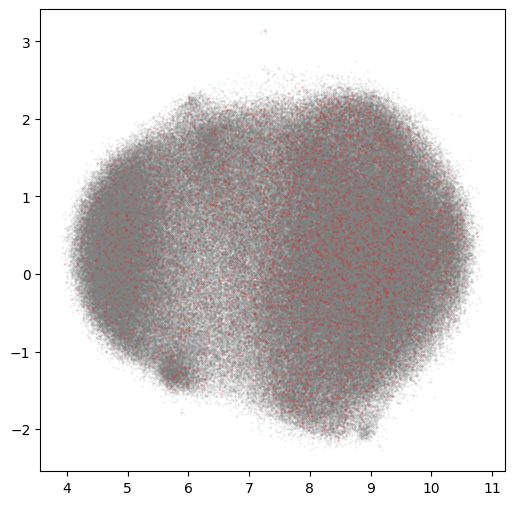

In [83]:
fig, ax = plt.subplots(figsize=(6,6))
# for i in range(10):
#     indices = np.where(y_train == i)
#     ax.scatter(u[indices,0], u[indices,1], s=.1, label=i)

# ax.legend(loc='upper right', markerscale=10)
ax.scatter(u[:,0], u[:,1], s=.1, color="gray", alpha=0.25)
ax.scatter(u[indices,0], u[indices,1], s=.1, color="red", alpha=0.25)